In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from datetime import datetime, timedelta
import seaborn as sns

In [ ]:
class StockPricePredictor:
    def __init__(self, stock_symbol: str, prediction_days: int = 60):
        """
        Initialize the stock price predictor.
        
        Args:
            stock_symbol: Stock ticker symbol (e.g., 'AAPL' for Apple)
            prediction_days: Number of previous days to use for prediction
        """
        self.stock_symbol = stock_symbol
        self.prediction_days = prediction_days
        self.scaler = MinMaxScaler(feature_range=(0, 1))
        self.model = None
        self.data = None
        self.scaled_data = None
        self.x_train = None
        self.y_train = None
        
    def fetch_data(self, start_date: str = '2015-01-01'):
        """
        Fetch stock data from Yahoo Finance.
        
        Args:
            start_date: Start date for historical data
        """
        try:
            self.data = yf.download(self.stock_symbol, start=start_date, end=datetime.now())
            print(f"Successfully downloaded data for {self.stock_symbol}")
            return True
        except Exception as e:
            print(f"Error fetching data: {e}")
            return False
            
    def prepare_data(self):
        """Prepare data for LSTM model."""
        # Scale the closing prices
        self.scaled_data = self.scaler.fit_transform(self.data['Close'].values.reshape(-1, 1))
        
        # Prepare training sequences
        x_train = []
        y_train = []
        
        for x in range(self.prediction_days, len(self.scaled_data)):
            x_train.append(self.scaled_data[x-self.prediction_days:x, 0])
            y_train.append(self.scaled_data[x, 0])
            
        self.x_train = np.array(x_train)
        self.y_train = np.array(y_train)
        self.x_train = np.reshape(self.x_train, 
                                (self.x_train.shape[0], self.x_train.shape[1], 1))
        
    def build_model(self):
        """Build and compile the LSTM model."""
        self.model = Sequential([
            LSTM(units=50, return_sequences=True, 
                 input_shape=(self.x_train.shape[1], 1)),
            Dropout(0.2),
            LSTM(units=50, return_sequences=True),
            Dropout(0.2),
            LSTM(units=50),
            Dropout(0.2),
            Dense(units=1)
        ])
        
        self.model.compile(optimizer=Adam(learning_rate=0.001),
                         loss='mean_squared_error')
        
        print("Model built successfully!")
        
    def train_model(self, epochs: int = 25, batch_size: int = 32):
        """
        Train the LSTM model.
        
        Args:
            epochs: Number of training epochs
            batch_size: Batch size for training
        """
        history = self.model.fit(self.x_train, self.y_train, 
                               epochs=epochs, batch_size=batch_size, 
                               validation_split=0.1,
                               verbose=1)
        return history
        
    def predict_next_day(self):
        """Predict the next day's closing price."""
        # Get the last 60 days of data
        last_60_days = self.scaled_data[-self.prediction_days:]
        next_day_input = np.reshape(last_60_days, (1, self.prediction_days, 1))
        
        # Make prediction and inverse transform
        prediction = self.model.predict(next_day_input)
        actual_prediction = self.scaler.inverse_transform(prediction)[0][0]
        
        current_price = self.data['Close'].iloc[-1]
        price_change = actual_prediction - current_price
        percentage_change = (price_change / current_price) * 100
        
        return actual_prediction, price_change, percentage_change
    
    def evaluate_model(self):
        """Evaluate model accuracy using recent predictions."""
        # Use last 30 days for testing
        test_start = len(self.data) - 30
        test_data = self.scaled_data[test_start - self.prediction_days:]
        
        x_test = []
        y_test = self.scaled_data[test_start:].reshape(-1)
        
        for x in range(self.prediction_days, len(test_data)):
            x_test.append(test_data[x-self.prediction_days:x, 0])
            
        x_test = np.array(x_test)
        x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
        
        predictions = self.model.predict(x_test)
        predictions = self.scaler.inverse_transform(predictions)
        actual_values = self.scaler.inverse_transform([y_test])
        
        # Calculate metrics
        mse = np.mean((predictions - actual_values.T) ** 2)
        rmse = np.sqrt(mse)
        mae = np.mean(np.abs(predictions - actual_values.T))
        
        return {
            'mse': mse,
            'rmse': rmse,
            'mae': mae,
            'predictions': predictions,
            'actual_values': actual_values.T
        }
    
    def plot_predictions(self, evaluation_results):
        """Plot actual vs predicted prices."""
        plt.figure(figsize=(12, 6))
        plt.plot(evaluation_results['actual_values'], 
                label='Actual Prices', color='blue')
        plt.plot(evaluation_results['predictions'], 
                label='Predicted Prices', color='red')
        plt.title(f'{self.stock_symbol} Stock Price Prediction Results')
        plt.xlabel('Time (days)')
        plt.ylabel('Stock Price')
        plt.legend()
        plt.grid(True)
        plt.show()
        
    def plot_training_history(self, history):
        """Plot training history."""
        plt.figure(figsize=(12, 6))
        plt.plot(history.history['loss'], label='Training Loss', color='blue')
        plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
        plt.title('Model Training History')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        plt.show()

2024-10-18 11:14:04.150291: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-18 11:14:04.344791: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-18 11:14:04.518204: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-18 11:14:04.726786: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-18 11:14:04.780985: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-18 11:14:05.056029: I tensorflow/core/platform/cpu_feature_gu

Enter stock symbol (e.g., AAPL):  AAPL


[*********************100%***********************]  1 of 1 completed
/home/solomon/Desktop/nea/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Successfully downloaded data for AAPL
Model built successfully!
Epoch 1/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 10s 70ms/step - loss: 0.0323 - val_loss: 0.0027
Epoch 2/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - loss: 0.0023 - val_loss: 0.0047
Epoch 3/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - loss: 0.0022 - val_loss: 0.0023
Epoch 4/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - loss: 0.0017 - val_loss: 0.0027
Epoch 5/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - loss: 0.0016 - val_loss: 0.0023
Epoch 6/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - loss: 0.0016 - val_loss: 0.0030
Epoch 7/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - loss: 0.0014 - val_loss: 0.0016
Epoch 8/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - loss: 0.0017 - val_loss: 0.0014
Epoch 9/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - loss: 0.0016 - val_loss: 0.0021
Epoch 10/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 69ms/step - loss: 0.0013 - val_loss: 0.0032
Epoch 11/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - loss: 0.0016 - val_loss: 0.002

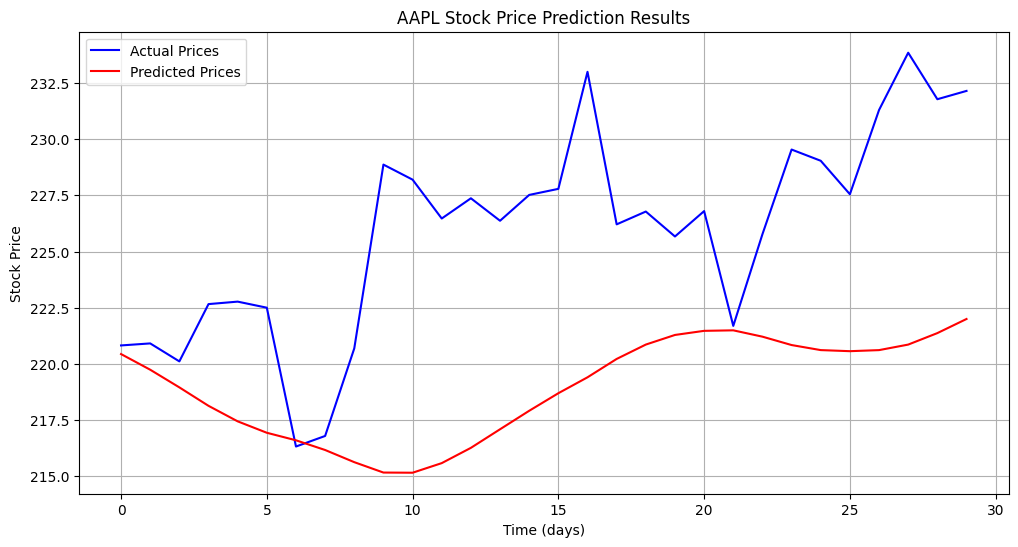

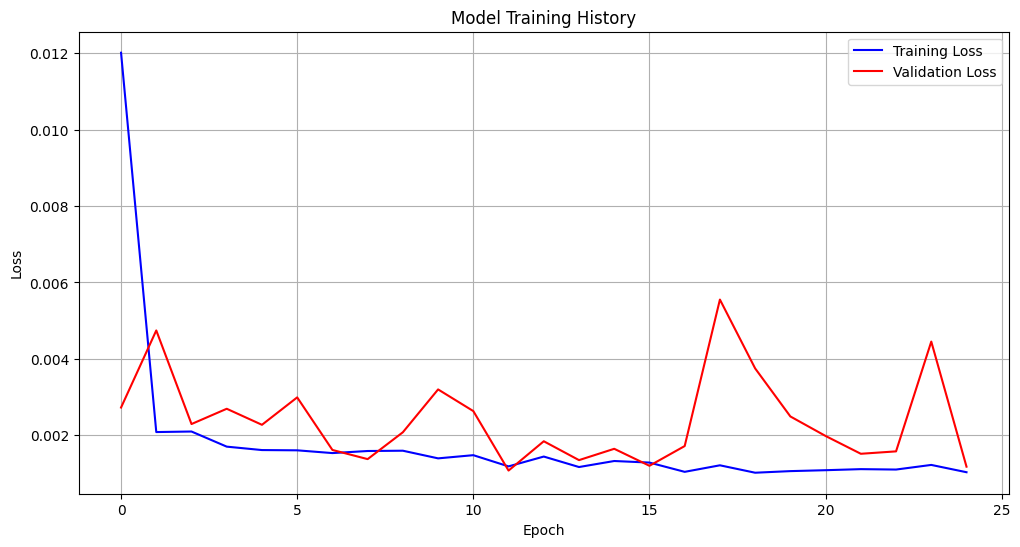

In [ ]:
# Example usage
def main():
    # Get user input
    stock_symbol = input("Enter stock symbol (e.g., AAPL): ").upper()
    
    # Initialize predictor
    predictor = StockPricePredictor(stock_symbol)
    
    # Fetch and prepare data
    if not predictor.fetch_data():
        print("Failed to fetch data. Please check the stock symbol and try again.")
        return
        
    predictor.prepare_data()
    
    # Build and train model
    predictor.build_model()
    history = predictor.train_model()
    
    # Make prediction for next day
    next_price, price_change, percentage_change = predictor.predict_next_day()
    print("\nPrediction Results:")
    print(f"Current Price: ${predictor.data['Close'].iloc[-1]:.2f}")
    print(f"Predicted Next Day Price: ${next_price:.2f}")
    print(f"Predicted Change: ${price_change:.2f} ({percentage_change:.2f}%)")
    
    # Evaluate model
    evaluation = predictor.evaluate_model()
    print("\nModel Accuracy Metrics:")
    print(f"Mean Squared Error: {evaluation['mse']:.2f}")
    print(f"Root Mean Squared Error: {evaluation['rmse']:.2f}")
    print(f"Mean Absolute Error: {evaluation['mae']:.2f}")
    
    # Plot results
    predictor.plot_predictions(evaluation)
    predictor.plot_training_history(history)

if __name__ == "__main__":
    main()